## Classification Model



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.datasets import load_boston
from feature_engine.outlier_removers import Winsorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [4]:
# load dataset

cols = [
    'Pclass','Sex','Age','Sib Sp','Parch','Fare','Cabin',
    'Embarked','Survived'
]

data = pd.read_csv('titanic.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Basic Exploration

Let's find out what types of variables there are in this dataset, statistical details, nulls, etc

In [5]:
# info to understand nulls & data types.
# clearly need to drop Cabin and identify further what to do about age
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have both  categorical and numerical variables.

In [6]:
# let's inspect the variable values.
# i fee like i can see some outliers in Fare which need to be treated
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# drop cabin
data = data.drop(['Cabin','PassengerId'],axis=1)

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Feature Engineering

In [8]:
# missing data, i'll need to treate Age,and embaraked maybe I'll just drop those rows

data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Embarked    0.002245
dtype: float64

In [9]:
data = data[data['Embarked'].notna()]

In [10]:
data.isnull().mean()

Survived    0.0000
Pclass      0.0000
Name        0.0000
Sex         0.0000
Age         0.1991
SibSp       0.0000
Parch       0.0000
Ticket      0.0000
Fare        0.0000
Embarked    0.0000
dtype: float64

There is missing data in our variables.

In [11]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[[
    'Pclass','Sex','Age','SibSp','Parch','Fare',
    'Embarked']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((622, 7), (267, 7))

In [12]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,622.000000,493.000000,622.000000,622.000000,622.000000
mean,2.319936,29.593996,0.538585,0.384244,31.107977
std,0.825648,14.939650,1.135416,0.844768,48.806957
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,30.500000
max,3.000000,80.000000,8.000000,6.000000,512.329200


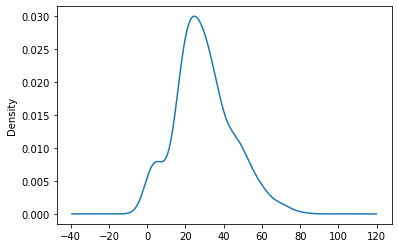

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Age'].plot(kind='kde', ax=ax)

In [14]:
# lets do some exploration of the dataset where there are only NA value
Xtrainull = X_train[X_train['Age'].isna()]

In [15]:
Xtrainull.describe()

,Pclass,Age,SibSp,Parch,Fare
count,129.000000,0.0,129.000000,129.000000,129.000000
mean,2.589147,NaN,0.511628,0.162791,21.734202
std,0.766612,NaN,1.601348,0.512206,33.893705
min,1.000000,NaN,0.000000,0.000000,0.000000
25%,3.000000,NaN,0.000000,0.000000,7.750000
50%,3.000000,NaN,0.000000,0.000000,7.895800
75%,3.000000,NaN,0.000000,0.000000,23.250000
max,3.000000,NaN,8.000000,2.000000,227.525000


In [16]:
# from this what I think I'll do is i'll take the median or mean age from females & males where pclass is 3 is null
Xtrainull[['Pclass']].groupby(Xtrainull['Sex']).describe()

Pclass                                             
        count      mean       std  min  25%  50%  75%  max
Sex                                                       
female   36.0  2.611111  0.766356  1.0  3.0  3.0  3.0  3.0
male     93.0  2.580645  0.770694  1.0  3.0  3.0  3.0  3.0

In [17]:
# I think I'll stick with just Age by gender & Pclass
Xtrainull.groupby(["Pclass", "Embarked","Sex"]).count()


Age  SibSp  Parch  Fare
Pclass Embarked Sex                            
1      C        female    0      3      3     3
                male      0      5      5     5
       S        female    0      3      3     3
                male      0     11     11    11
2      C        male      0      1      1     1
       Q        female    0      1      1     1
       S        female    0      1      1     1
                male      0      6      6     6
3      C        female    0      4      4     4
                male      0     12     12    12
       Q        female    0     15     15    15
                male      0     20     20    20
       S        female    0      9      9     9
                male      0     38     38    38

In [18]:
X_train.groupby(['Sex','Pclass'])['Age'].describe()

count       mean        std   min    25%   50%    75%   max
Sex    Pclass                                                             
female 1        54.0  35.166667  14.124447  2.00  24.00  35.0  47.75  63.0
       2        56.0  28.285714  13.157389  3.00  21.75  28.0  34.50  57.0
       3        68.0  21.224265  12.695570  0.75  10.75  20.5  29.00  48.0
male   1        68.0  42.080882  15.504359  4.00  28.75  43.0  51.25  80.0
       2        70.0  32.123857  14.649526  0.67  24.00  31.0  41.25  70.0
       3       177.0  25.725537  12.560649  0.42  19.00  24.5  33.00  74.0

In [19]:
X_train.groupby(['Sex','Pclass'])['Age'].median().round()

Sex     Pclass
female  1         35.0
        2         28.0
        3         20.0
male    1         43.0
        2         31.0
        3         24.0
Name: Age, dtype: float64

In [20]:
# replace Na values with the means of ages by Pclass 3
X_train.loc[(X_train.Age.isnull())&(X_train.Sex=='female'),'Age']=21
X_train.loc[(X_train.Age.isnull())&(X_train.Sex=='male'),'Age']=26

In [21]:
# no nulls though I'll need to deal with those objects through one hot encoding later
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 351 to 685
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    622 non-null    int64  
 1   Sex       622 non-null    object 
 2   Age       622 non-null    float64
 3   SibSp     622 non-null    int64  
 4   Parch     622 non-null    int64  
 5   Fare      622 non-null    float64
 6   Embarked  622 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 38.9+ KB


In [22]:
X_train.loc[(X_train.Age.isnull())&(X_train.Sex=='female'),'Age']=21
X_train.loc[(X_train.Age.isnull())&(X_train.Sex=='male'),'Age']=26

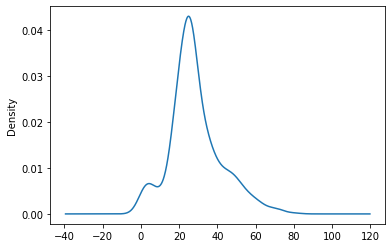

In [23]:
# original distribution has not changed! Good
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Age'].plot(kind='kde', ax=ax)

In [24]:
# outliers

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

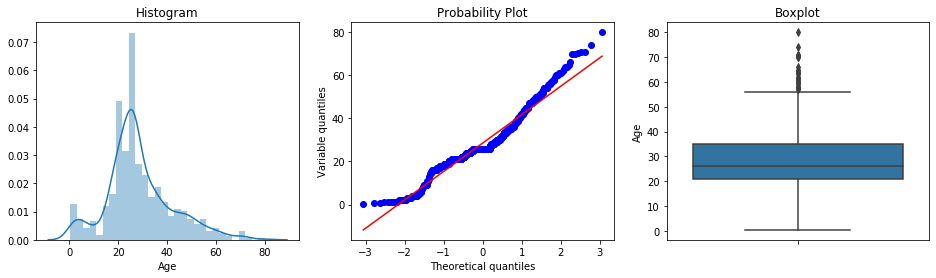

In [25]:
# There doesn't appear anything crazy here about age outliers. You can have old people on the ship
diagnostic_plots(X_train,'Age')

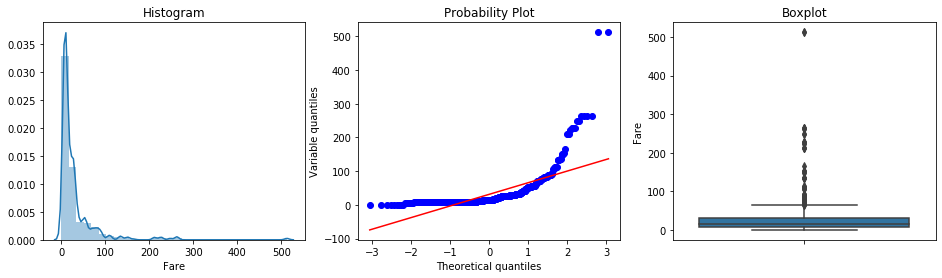

In [26]:
# ok now we have someoutliers here,need to do a deep dive
diagnostic_plots(X_train,'Fare')

In [27]:
# some rich people have spent top dollar for their tickets
X_train.groupby(['Pclass'])['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,144.0,82.573553,79.912336,0.0,30.6958,55.67085,90.000,512.3292
2,135.0,19.807253,11.702863,0.0,12.7625,13.85830,26.000,73.5000
3,343.0,13.949245,11.860248,0.0,7.7500,8.05000,15.525,69.5500


In [28]:
def find_skewed_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [29]:
# find limits for Fare

XtrainFare = X_train[X_train['Pclass']==1]
XtrainFare.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
351,1,male,26.0,0,0,35.0000,S
694,1,male,60.0,0,0,26.5500,S
621,1,male,42.0,1,0,52.5542,S
609,1,female,40.0,0,0,153.4625,S
453,1,male,49.0,1,0,89.1042,C


In [30]:
# find limits. I'll use these as caps
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(XtrainFare, 'Fare', 1.5)
RM_upper_limit, RM_lower_limit

(178.9563, -58.2605)

In [31]:
X_train['Fare']= np.where(X_train['Fare']> RM_upper_limit, RM_upper_limit,
                       np.where(X_train['Fare']< RM_lower_limit, RM_lower_limit,X_train['Fare']))

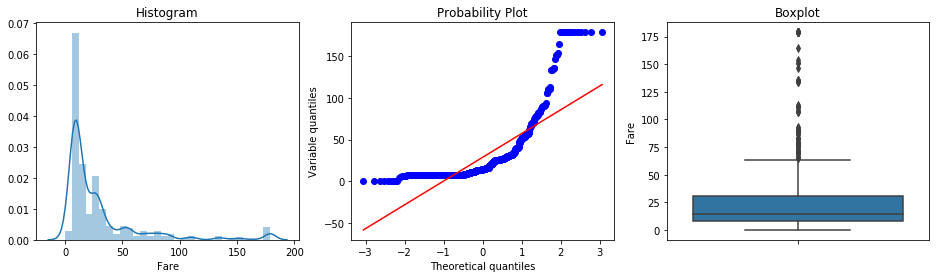

In [32]:
# ok now we have someoutliers here,need to do a deep dive
diagnostic_plots(X_train,'Fare')

In [33]:
# values bigger than 3 are rare for parch so no worries about outlier treatment

X_train['Parch'].value_counts()

0    478
1     78
2     53
5      5
3      4
4      3
6      1
Name: Parch, dtype: int64

In [34]:
X_train['Sex'].value_counts()

male      408
female    214
Name: Sex, dtype: int64

In [35]:
X_train['SibSp'].value_counts()

0    424
1    144
2     20
4     16
3      9
8      5
5      4
Name: SibSp, dtype: int64

In [36]:
# replace na values in Test Dataset.You preserve outliers in test data
X_test.loc[(X_test.Age.isnull())&(X_test.Sex=='female'),'Age']=21
X_test.loc[(X_test.Age.isnull())&(X_test.Sex=='male'),'Age']=26

In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 14 to 52
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    267 non-null    int64  
 1   Sex       267 non-null    object 
 2   Age       267 non-null    float64
 3   SibSp     267 non-null    int64  
 4   Parch     267 non-null    int64  
 5   Fare      267 non-null    float64
 6   Embarked  267 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 16.7+ KB


I don't see why I need to standardize or normalize for this classificaiton model. The research shows that is not neccesary. However before feature engineering I need to one hot encode

In [38]:
# One Hot Encoding

tmp = pd.get_dummies(X_train['Sex'])
tmp.head()

,female,male
351,0,1
125,0,1
578,1,0
423,1,0
119,1,0


In [39]:
pd.concat([X_train['Sex'],
           pd.get_dummies(X_train['Sex'])], axis=1).head()

,Sex,female,male
351,male,0,1
125,male,0,1
578,female,1,0
423,female,1,0
119,female,1,0


In [40]:
tmp = pd.get_dummies(X_train['Embarked'])

tmp.head()

,C,Q,S
351,0,0,1
125,1,0,0
578,1,0,0
423,0,0,1
119,0,0,1


In [41]:
# for better visualisation

pd.concat([X_train['Embarked'],
           pd.get_dummies(X_train['Embarked'])], axis=1).head()

,Embarked,C,Q,S
351,S,0,0,1
125,C,1,0,0
578,C,1,0,0
423,S,0,0,1
119,S,0,0,1


In [42]:
X_train = pd.get_dummies(X_train)

print(X_train.shape)

X_train.head()

(622, 10)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
351,1,26.0,0,0,35.0000,0,1,0,0,1
125,3,12.0,1,0,11.2417,0,1,1,0,0
578,3,21.0,1,0,14.4583,1,0,1,0,0
423,3,28.0,1,1,14.4000,1,0,0,0,1
119,3,2.0,4,2,31.2750,1,0,0,0,1


In [43]:
X_test = pd.get_dummies(X_test)

print(X_test.shape)

X_test.head()

(267, 10)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
14,3,14.0,0,0,7.8542,1,0,0,0,1
159,3,26.0,8,2,69.5500,0,1,0,0,1
763,1,36.0,1,2,120.0000,1,0,0,0,1
741,1,36.0,1,0,78.8500,0,1,0,0,1
483,3,63.0,0,0,9.5875,1,0,0,0,1


In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 14 to 52
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      267 non-null    int64  
 1   Age         267 non-null    float64
 2   SibSp       267 non-null    int64  
 3   Parch       267 non-null    int64  
 4   Fare        267 non-null    float64
 5   Sex_female  267 non-null    uint8  
 6   Sex_male    267 non-null    uint8  
 7   Embarked_C  267 non-null    uint8  
 8   Embarked_Q  267 non-null    uint8  
 9   Embarked_S  267 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 13.8 KB


In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 351 to 685
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      622 non-null    int64  
 1   Age         622 non-null    float64
 2   SibSp       622 non-null    int64  
 3   Parch       622 non-null    int64  
 4   Fare        622 non-null    float64
 5   Sex_female  622 non-null    uint8  
 6   Sex_male    622 non-null    uint8  
 7   Embarked_C  622 non-null    uint8  
 8   Embarked_Q  622 non-null    uint8  
 9   Embarked_S  622 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 32.2 KB


In [82]:
enc = OneHotEncoder()
enc.fit(X_train)

NameError: name 'OneHotEncoder' is not defined

# Feature Selection

In [46]:
# keep copy of original
X_train_original = X_train.copy()
X_test_original = X_test.copy()

In [47]:
X_train.shape

(622, 10)

In [48]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((622, 10), (267, 10))

In [49]:
# remove quasi constant
sel = VarianceThreshold(
    threshold=0.01)  
sel.fit(X_train)  

sum(sel.get_support()) 

10

In [50]:
features_to_keep = X_train.columns[sel.get_support()]

In [51]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((622, 10), (267, 10))

In [52]:
#transform the arrays back to dataframes
X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

In [53]:
# check for duplicated features in the training set and there are none
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0


0

In [54]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((622, 10), (267, 10))

In [55]:
# keep a copy of the dataset up till now

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

In [56]:
# find and remove correlated features which thankfully happen to only be one
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  1


In [57]:
# this makes sense because with male and female it's either one or the other
corr_features

{'Sex_male'}

In [58]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)
X_train.shape, X_test.shape

((622, 9), (267, 9))

In [59]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

In [60]:
# find important features using univariate roc-auc
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

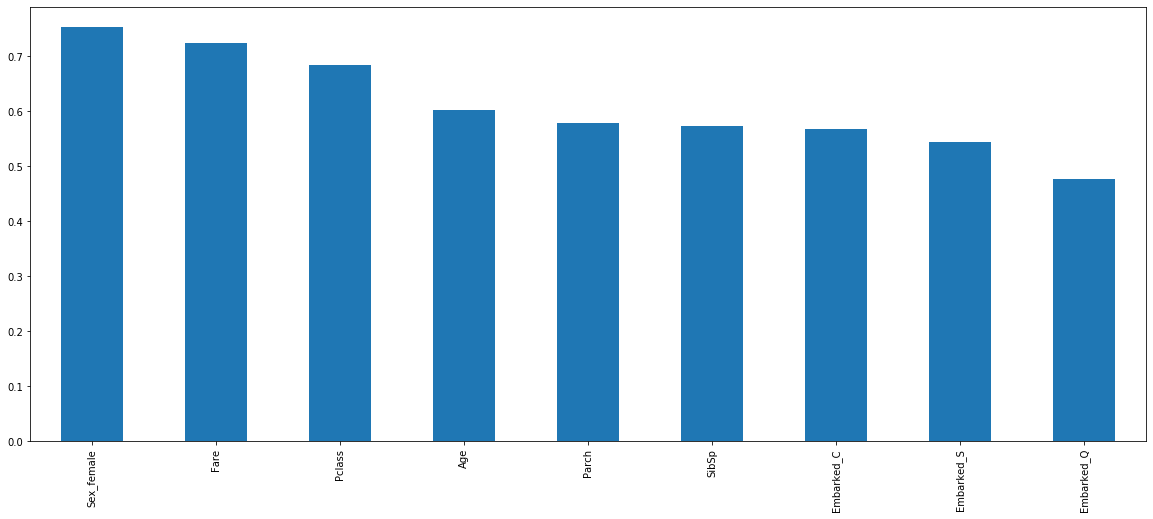

In [61]:
# let's add the variable names and order it for clearer visualisation. There is nothing to be gained from filtering out variables greater than .5
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [62]:
# Remove Features with Lasso
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
# fit a lasso and selet features, make sure to select l2
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(X_train), y_train)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]

In [64]:
X_train_lasso.shape, X_test_lasso.shape

((622, 3), (267, 3))

In [65]:
# This is not unreasonable actually
X_train_lasso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      622 non-null    float64
 1   Age         622 non-null    float64
 2   Sex_female  622 non-null    float64
dtypes: float64(3)
memory usage: 14.7 KB


### Putting it all together

In [66]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [67]:
# original
run_randomForests(X_train_original,
                  X_test_original,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9053072315882875
Test set
Random Forests roc-auc: 0.839200926462073


In [68]:
# filter methods - basic
run_randomForests(X_train_basic_filter,
                  X_test_basic_filter,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9053072315882875
Test set
Random Forests roc-auc: 0.839200926462073


In [69]:
# filter methods - correlation
run_randomForests(X_train_corr,
                  X_test_corr,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9073535936113576
Test set
Random Forests roc-auc: 0.8403011001737116


In [70]:
# embedded methods - Lasso
run_randomForests(X_train_lasso,
                  X_test_lasso,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9036657054125998
Test set
Random Forests roc-auc: 0.8298204979733643


In [71]:
def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [73]:
# original
scaler = StandardScaler().fit(X_train_original)

run_logistic(scaler.transform(X_train_original),
             scaler.transform(X_test_original),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8698480479148182
Test set
Logistic Regression roc-auc: 0.8189924724956572


In [74]:
scaler = StandardScaler().fit(X_train_basic_filter)

run_logistic(scaler.transform(X_train_basic_filter),
             scaler.transform(X_test_basic_filter),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8698480479148182
Test set
Logistic Regression roc-auc: 0.8189924724956572


In [75]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr)

run_logistic(scaler.transform(X_train_corr),
             scaler.transform(X_test_corr),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8697482253771073
Test set
Logistic Regression roc-auc: 0.8188766647365373


In [80]:
scaler = StandardScaler().fit(X_train_lasso)

run_logistic(scaler.transform(X_train_lasso),
             scaler.transform(X_test_lasso),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8565439219165927
Test set
Logistic Regression roc-auc: 0.8196583671105964
